# Fine-tuning PaliGemma 2 for JSON Data Extraction using Maestro

---

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/maestro/blob/develop/cookbooks/maestro_paligemma_2_json_extraction.ipynb)
[![dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/pallet-load-manifest)

## Environment setup

### Configure your API keys

To fine-tune PaliGemma 2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (ðŸ”‘).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `A100 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Feb  5 07:03:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install "maestro[paligemma_2]"
!pip install roboflow

## Download and prepare dataset

The dataset is sourced from Roboflow and is structured in JSONL format. Using the Roboflow API, we authenticate, select a workspace and project, and download the dataset.


In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("roboflow-jvuqo")
project = workspace.project("pallet-load-manifest-json")
version = project.version(2)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pallet-load-manifest-json-2 in jsonl:: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 178/178 [00:00<00:00, 4796.39it/s]


In [4]:
!head -n 1 {dataset.location}/train/annotations.jsonl

{"image":"IMG_3128_jpg.rf.050d52dec36d353a43a9eba664c28ad3.jpg","prefix":"<JSON>","suffix":"{\"route\": \"D452-SU-275\",\"pallet_number\": \"15\",\"delivery_date\": \"1/11/2024\",\"load\": \"1\",\"dock\": \"D05\",\"shipment_id\": \"K77912144793\",\"destination\": \"82135 Robert Harbors Apt. 285, Marquezhaven, AZ 68208\",\"asn_number\": \"1338742991\",\"salesman\": \"KIMBERLY GARCIA\",\"products\": [{\"description\": \"223606 - CASE OF MICROFIBER SPONGES\",\"cases\": \"4\",\"sales_units\": \"4\",\"layers\": \"5\"},{\"description\": \"728495 - BOX OF STAIN REMOVERS\",\"cases\": \"64\",\"sales_units\": \"2\",\"layers\": \"4\"},{\"description\": \"112233 - CASE OF DISH SOAP\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"1\"},{\"description\": \"847395 - CASE OF SQUEEGEES\",\"cases\": \"4\",\"sales_units\": \"32\",\"layers\": \"1\"},{\"description\": \"963741 - 12PK OF DISINFECTANT WIPES\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"2\"},{\"description\": \"258963 - CASE 

In [5]:
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/train/annotations.jsonl
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/valid/annotations.jsonl
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/test/annotations.jsonl

In [6]:
!head -n 1 {dataset.location}/train/annotations.jsonl

{"image":"IMG_3128_jpg.rf.050d52dec36d353a43a9eba664c28ad3.jpg","prefix":"extract data in JSON format","suffix":"{\"route\": \"D452-SU-275\",\"pallet_number\": \"15\",\"delivery_date\": \"1/11/2024\",\"load\": \"1\",\"dock\": \"D05\",\"shipment_id\": \"K77912144793\",\"destination\": \"82135 Robert Harbors Apt. 285, Marquezhaven, AZ 68208\",\"asn_number\": \"1338742991\",\"salesman\": \"KIMBERLY GARCIA\",\"products\": [{\"description\": \"223606 - CASE OF MICROFIBER SPONGES\",\"cases\": \"4\",\"sales_units\": \"4\",\"layers\": \"5\"},{\"description\": \"728495 - BOX OF STAIN REMOVERS\",\"cases\": \"64\",\"sales_units\": \"2\",\"layers\": \"4\"},{\"description\": \"112233 - CASE OF DISH SOAP\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"1\"},{\"description\": \"847395 - CASE OF SQUEEGEES\",\"cases\": \"4\",\"sales_units\": \"32\",\"layers\": \"1\"},{\"description\": \"963741 - 12PK OF DISINFECTANT WIPES\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"2\"},{\"descriptio

## Train PaliGemma 2 with maestro

The training process is initiated using Maestro's `train` function. The system message is configured to instruct the model to extract structured JSON data from pallet manifest images. The training is run using 10 epochs with a batch size of 4. The optimization strategy used is `lora`, which allows for efficient fine-tuning of large models. The metrics tracked during training are `edit_distance` and `bleu`, which help evaluate the accuracy of JSON extraction.


In [ ]:
from maestro.trainer.models.paligemma_2.core import train

config = {
    "model_id": "google/paligemma2-3b-pt-448",
    "dataset": dataset.location,
    "lr": 1e-4,
    "epochs": 5,
    "batch_size": 1,
    "num_workers": 10,
    "optimization_strategy": "lora",
    "metrics": ["edit_distance", "bleu"],
}

train(config)

## Examine training results

After training, we examine the results by listing available metric files and visualizing the loss, edit distance, and BLEU plots. These metrics help assess model performance, tracking how well the model aligns with ground truth JSON extractions.


In [8]:
!ls -la /content/training/paligemma_2/1/metrics

total 100
drwxr-xr-x 2 root root  4096 Feb  5 07:18 .
drwxr-xr-x 4 root root  4096 Feb  5 07:18 ..
-rw-r--r-- 1 root root 26297 Feb  5 07:18 bleu_plot.png
-rw-r--r-- 1 root root 29183 Feb  5 07:18 edit_distance_plot.png
-rw-r--r-- 1 root root 30131 Feb  5 07:18 loss_plot.png


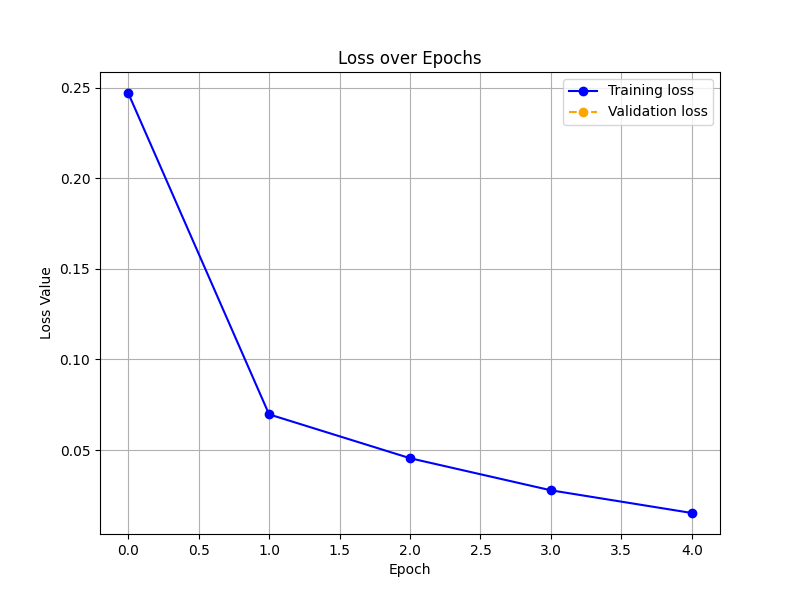

In [9]:
from IPython.display import Image

Image(filename="/content/training/paligemma_2/1/metrics/loss_plot.png", height=600)

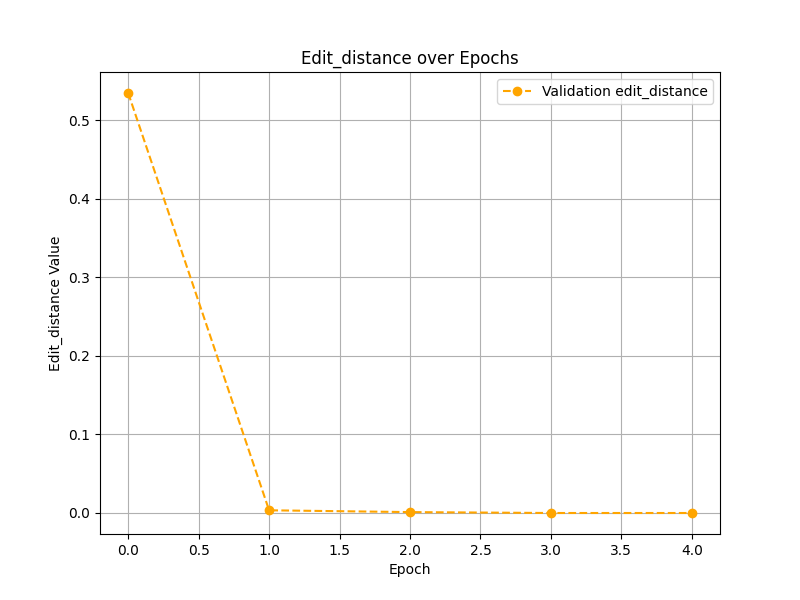

In [10]:
from IPython.display import Image

Image(filename="/content/training/paligemma_2/1/metrics/edit_distance_plot.png", height=600)

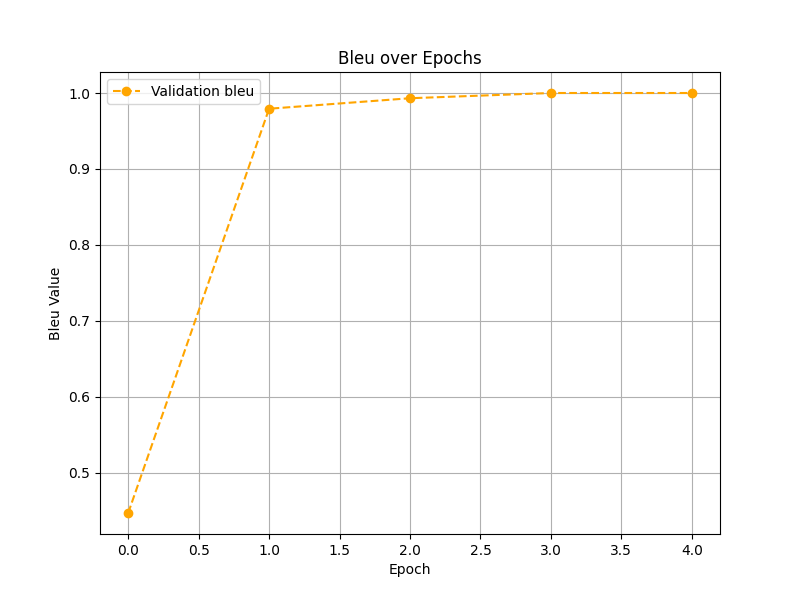

In [11]:
from IPython.display import Image

Image(filename="/content/training/paligemma_2/1/metrics/bleu_plot.png", height=600)

## Run inference with fine-tuned PaliGemma 2 model

We load the fine-tuned PaliGemma 2 model and run inference on test images. The `predict` function generates structured JSON output, which is parsed and verified for correctness.


In [ ]:
from maestro.trainer.models.paligemma_2.checkpoints import OptimizationStrategy, load_model

processor, model = load_model(
    model_id_or_path="/content/training/paligemma_2/1/checkpoints/latest",
    optimization_strategy=OptimizationStrategy.NONE,
)

In [13]:
from maestro.trainer.common.datasets import RoboflowJSONLDataset

ds = RoboflowJSONLDataset(
    jsonl_file_path=f"{dataset.location}/test/annotations.jsonl",
    image_directory_path=f"{dataset.location}/test",
)

image, entry = ds[0]

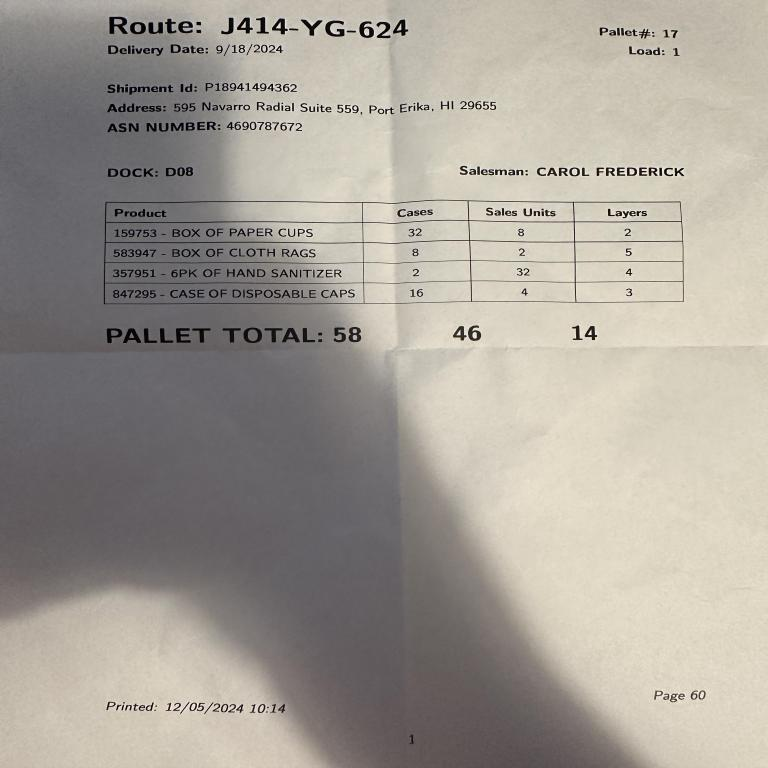

In [14]:
image

In [16]:
import json

from maestro.trainer.models.paligemma_2.inference import predict

generated_suffix = predict(model=model, processor=processor, image=image, prefix=entry["prefix"])
json.loads(generated_suffix)

{'route': 'J414-YG-624',
 'pallet_number': '17',
 'delivery_date': '9/18/2024',
 'load': '1',
 'dock': 'D08',
 'shipment_id': 'P18941494362',
 'destination': '595 Navarro Radial Suite 559, Port Erika, HI 29655',
 'asn_number': '4690787672',
 'salesman': 'CAROL FREDERICK',
 'products': [{'description': '159753 - BOX OF PAPER CUPS',
   'cases': '32',
   'sales_units': '8',
   'layers': '2'},
  {'description': '583947 - BOX OF CLOTH RAGS',
   'cases': '8',
   'sales_units': '2',
   'layers': '5'},
  {'description': '357951 - 6PK OF HAND SANITIZER',
   'cases': '2',
   'sales_units': '32',
   'layers': '4'},
  {'description': '847295 - CASE OF DISPOSABLE CAPS',
   'cases': '16',
   'sales_units': '4',
   'layers': '3'}],
 'total_cases': '58',
 'total_units': '46',
 'total_layers': '14',
 'printed_date': '12/05/2024 10:14',
 'page_number': '60'}

## More Vision-Language Models

Now that you have fine-tuned PaliGemma 2 for JSON data extraction, why not experiment with other vision-language models and different vision tasks? You can explore more at [Maestro Documentation](https://maestro.roboflow.com/) or the [Maestro GitHub](https://github.com/roboflow/maestro). If you find a bug or have feature ideas, submit an issue at [GitHub Issues](https://github.com/roboflow/maestro/issues).
